In [10]:
import matplotlib.pyplot as plt

import numpy as np
import torch

from models import MLP
from datas import get_dataset_2d_regression

# Data Set

In [11]:

trainset, trainloader, testset, testloader, classes = get_dataset_2d_regression(32)
print(len(trainloader))

15


# Model

In [12]:
in_dim, out_dim, hidden_dim, num_hidden_layers = 2, 1, 8, 4
model = MLP(in_dim, out_dim, hidden_dim, num_hidden_layers)

# Train

In [13]:
def get_model_dtype(model):
    return next(model.parameters()).dtype

## Preprocessing
In regression setting, a preprocess would be needed. As we already know the mean = (0, 0) and diag(cov) = 33. The labels having mean  66.21, std 53.62

In [17]:
device = 'cuda'
model = model.to(device)
dtype = get_model_dtype(model)
losser = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
print(dtype)
num_epoch = 20

label_mean = 66.21
label_std = 53.62

sample_mean = torch.tensor([0, 0], dtype=dtype, device=device,)
sample_std = torch.tensor([5.773, 5.773], dtype=dtype, device=device,)

def preprocess(samples, labels):
    samples = (samples - sample_mean) / sample_std
    labels = (labels - label_mean) / label_std
    return samples, labels

def denorm_pred(pred):
    labels = pred * label_std + label_mean
    return labels

torch.float32


In [18]:
epoch_eval_losses = []
epoch_train_avg_loss = []
batch_losses = []
for epoch in range(num_epoch):
    epoch_train_losses = []
    for batch in trainloader:
        samples, labels = batch
        samples = samples.to('cuda', dtype=dtype)
        labels = labels.to('cuda', dtype=dtype)
        samples, labels = preprocess(samples, labels)
        pred = model(samples)[:, 0] # take the last output
        loss = losser(pred, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_losses.append(loss.item())
    
    eval_loss, num_samples = 0, 0
    for batch in testloader:
        with torch.no_grad():
            samples, labels = batch
            samples = samples.to('cuda', dtype=dtype)
            labels = labels.to('cuda', dtype=dtype)
            samples, norm_labels = preprocess(samples, labels)
            pred = model(samples)[:, 0]
            denormed_pred = denorm_pred(pred)
            eval_loss += torch.square(pred - norm_labels).sum()
            num_samples += pred.shape[0]
    
    epoch_train_losses = np.array(epoch_train_losses).mean()
    epch_eval_loss = eval_loss/num_samples
    epoch_train_avg_loss.append(epoch_train_losses.item())
    epoch_eval_losses.append(epch_eval_loss.item())
    batch_losses.extend(epoch_train_avg_loss) 

    print(f'epoch {epoch}, train avg loss {epoch_train_losses}, eval error {epch_eval_loss: .02f}')

epoch 0, train avg loss 1.118147109945615, eval error  1.20
epoch 1, train avg loss 1.0955231606960296, eval error  1.16
epoch 2, train avg loss 1.1467498620351155, eval error  1.12
epoch 3, train avg loss 1.056322548786799, eval error  1.08
epoch 4, train avg loss 1.1530189275741578, eval error  1.03
epoch 5, train avg loss 1.1718379457791646, eval error  0.98
epoch 6, train avg loss 1.021507235368093, eval error  0.94
epoch 7, train avg loss 1.0370671947797139, eval error  0.92
epoch 8, train avg loss 0.954003099600474, eval error  0.91
epoch 9, train avg loss 0.8661593248446783, eval error  0.91
epoch 10, train avg loss 0.967836719751358, eval error  0.91
epoch 11, train avg loss 0.8425868153572083, eval error  0.91
epoch 12, train avg loss 0.6876633872588476, eval error  0.92
epoch 13, train avg loss 0.6755106409390768, eval error  0.95
epoch 14, train avg loss 0.6378540933132172, eval error  0.98
epoch 15, train avg loss 0.4781428759296735, eval error  1.02
epoch 16, train avg los

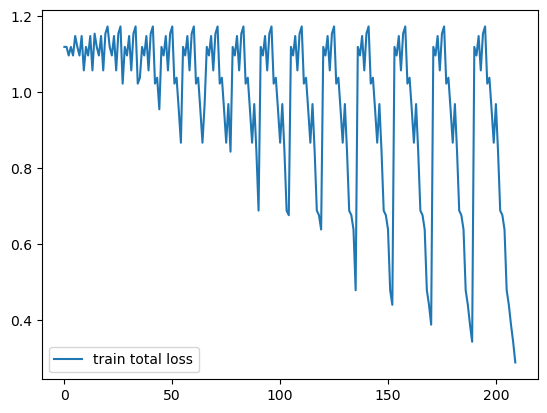

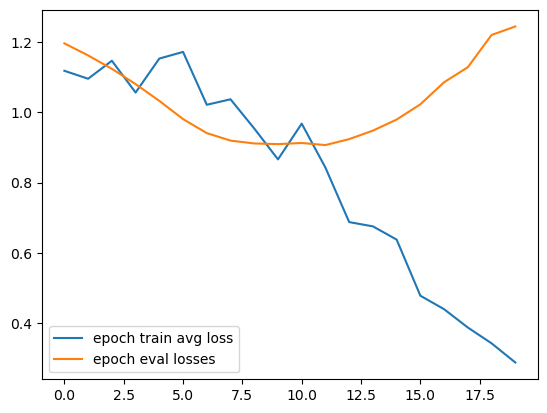

In [20]:
plt.plot(batch_losses, label='train total loss')
plt.legend()
plt.show()

plt.plot(epoch_train_avg_loss, label='epoch train avg loss')
plt.plot(epoch_eval_losses, label='epoch eval losses')
plt.legend()
